In [ ]:
!pip install pyspan


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 82.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.1.4 which is incompatible.


In [ ]:
import pandas as pd
import pyspan

# Load the Electric Vehicle Charging Patterns dataset
df = pd.read_csv('ev_charging_patterns.csv')

# Check the first few rows of the dataset
print(df.head())


  User ID Vehicle Model  Battery Capacity (kWh) Charging Station ID  \
0  User_1        BMW i3              108.463007         Station_391   
1  User_2  Hyundai Kona              100.000000         Station_428   
2  User_3    Chevy Bolt               75.000000         Station_181   
3  User_4  Hyundai Kona               50.000000         Station_327   
4  User_5  Hyundai Kona               50.000000         Station_108   

  Charging Station Location  Charging Start Time    Charging End Time  \
0                   Houston  2024-01-01 00:00:00  2024-01-01 00:39:00   
1             San Francisco  2024-01-01 01:00:00  2024-01-01 03:01:00   
2             San Francisco  2024-01-01 02:00:00  2024-01-01 04:48:00   
3                   Houston  2024-01-01 03:00:00  2024-01-01 06:42:00   
4               Los Angeles  2024-01-01 04:00:00  2024-01-01 05:46:00   

   Energy Consumed (kWh)  Charging Duration (hours)  Charging Rate (kW)  \
0              60.712346                   0.591363        

**1.HANDLING MISSING DATA**

In [ ]:
# Checking for missing values in each column
print(df.isnull().sum())

User ID                                      0
Vehicle Model                                0
Battery Capacity (kWh)                       0
Charging Station ID                          0
Charging Station Location                    0
Charging Start Time                          0
Charging End Time                            0
Energy Consumed (kWh)                       66
Charging Duration (hours)                    0
Charging Rate (kW)                          66
Charging Cost (USD)                          0
Time of Day                                  0
Day of Week                                  0
State of Charge (Start %)                    0
State of Charge (End %)                      0
Distance Driven (since last charge) (km)    66
Temperature (°C)                             0
Vehicle Age (years)                          0
Charger Type                                 0
User Type                                    0
dtype: int64


In [ ]:
# Remove rows with missing values in the specified columns
df = pyspan.handle_nulls(df, columns=['Energy Consumed (kWh)', 'Charging Rate (kW)', 'Distance Driven (since last charge) (km)'], action='remove')

# Check if the rows were removed
print(df.isnull().sum())

User ID                                     0
Vehicle Model                               0
Battery Capacity (kWh)                      0
Charging Station ID                         0
Charging Station Location                   0
Charging Start Time                         0
Charging End Time                           0
Energy Consumed (kWh)                       0
Charging Duration (hours)                   0
Charging Rate (kW)                          0
Charging Cost (USD)                         0
Time of Day                                 0
Day of Week                                 0
State of Charge (Start %)                   0
State of Charge (End %)                     0
Distance Driven (since last charge) (km)    0
Temperature (°C)                            0
Vehicle Age (years)                         0
Charger Type                                0
User Type                                   0
dtype: int64


Missing values in critical columns like 'Energy Consumed (kWh)', 'Charging Rate (kW)', and 'Distance Driven (since last charge) (km)' were addressed by removing rows with nulls.

**2.CHECKING FOR DUPLICATES AND IF ANY THEN REMOVING THEM**

In [ ]:
# Check for duplicate rows in the dataset based on all columns
duplicates = df[df.duplicated()]

# Print the number of duplicate rows
print(f"Number of duplicate rows: {len(duplicates)}")


Number of duplicate rows: 0


3.**CONVERTING DATA TYPES:**

In [ ]:
# Convert 'Charging Start Time' and 'Charging End Time' to datetime using pyspan (you may convert manually if pyspan doesn't have a direct method)
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'])
df['Charging End Time'] = pd.to_datetime(df['Charging End Time'])

# Check the data types after conversion
print(df.dtypes)



User ID                                             object
Vehicle Model                                       object
Battery Capacity (kWh)                             float64
Charging Station ID                                 object
Charging Station Location                           object
Charging Start Time                         datetime64[ns]
Charging End Time                           datetime64[ns]
Energy Consumed (kWh)                              float64
Charging Duration (hours)                          float64
Charging Rate (kW)                                 float64
Charging Cost (USD)                                float64
Time of Day                                         object
Day of Week                                         object
State of Charge (Start %)                          float64
State of Charge (End %)                            float64
Distance Driven (since last charge) (km)           float64
Temperature (°C)                                   float

Columns such as 'Charging Start Time' and 'Charging End Time' were converted to proper datetime types, and numerical columns like 'Battery Capacity (kWh)' and 'Vehicle Age (years)' were formatted correctly.

**4.Text Standardization:**

In [ ]:
# Standardizing string columns (removing extra spaces and converting to lowercase)
df['Charging Station Location'] = df['Charging Station Location'].str.strip().str.lower()
df['Vehicle Model'] = df['Vehicle Model'].str.strip().str.lower()
df['Charger Type'] = df['Charger Type'].str.strip().str.lower()
df['User Type'] = df['User Type'].str.strip().str.lower()

# Verifying the changes
print(df[['Charging Station Location', 'Vehicle Model', 'Charger Type', 'User Type']].head())


  Charging Station Location Vehicle Model     Charger Type  \
0                   houston        bmw i3  dc fast charger   
1             san francisco  hyundai kona          level 1   
2             san francisco    chevy bolt          level 2   
3                   houston  hyundai kona          level 1   
4               los angeles  hyundai kona          level 1   

                User Type  
0                commuter  
1           casual driver  
2                commuter  
3  long-distance traveler  
4  long-distance traveler  


Text columns like 'Charging Station Location', 'Vehicle Model', and 'Charger Type' were standardized to lowercase for consistency.

**5.Outlier Detection and Removal:**

In [ ]:
# Handling outliers using IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Flagging potential outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Outliers detected in {column}: {len(outliers)}")

    return outliers

# Apply the function to the numerical columns
for col in ['Energy Consumed (kWh)', 'Charging Rate (kW)', 'Distance Driven (since last charge) (km)', 'Temperature (°C)']:
    detect_outliers_iqr(df, col)


Outliers detected in Energy Consumed (kWh): 2
Outliers detected in Charging Rate (kW): 1
Outliers detected in Distance Driven (since last charge) (km): 0
Outliers detected in Temperature (°C): 2


In [ ]:
def remove_outliers_iqr(df, column):
    # Calculate the IQR for the column
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to remove outliers
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df_cleaned

# Remove outliers for each relevant column
df = remove_outliers_iqr(df, 'Energy Consumed (kWh)')
df = remove_outliers_iqr(df, 'Charging Rate (kW)')
df = remove_outliers_iqr(df, 'Temperature (°C)')

# Check the number of rows after outlier removal
print(f"Number of rows after removing outliers: {len(df)}")


Number of rows after removing outliers: 1126


 Outliers were detected and removed from 'Energy Consumed (kWh)', 'Charging Rate (kW)', 'Distance Driven (since last charge) (km)', and 'Temperature (°C)' using IQR method.

**6.Extreme Value Handling:**

In [ ]:
# Capping 'Temperature (°C)' at 50°C
df['Temperature (°C)'] = df['Temperature (°C)'].apply(lambda x: min(x, 50))

# Checking the changes
print(df['Temperature (°C)'].describe())



count    1126.000000
mean       15.169909
std        14.529898
min       -10.724770
25%         2.905961
50%        14.592205
75%        27.805093
max        50.000000
Name: Temperature (°C), dtype: float64


Temperature: Temperature values greater than 50°C were capped at 50°C.


In [ ]:
# Investigating the vehicle age of 0 entries
vehicle_age_zeros = df[df['Vehicle Age (years)'] == 0]
print(f"Number of entries with Vehicle Age = 0: {len(vehicle_age_zeros)}")

# If needed, fill them with a small value, like 1, assuming it's a new vehicle
df['Vehicle Age (years)'] = df['Vehicle Age (years)'].replace(0, 1)

# Checking the changes
print(df['Vehicle Age (years)'].describe())


Number of entries with Vehicle Age = 0: 125
count    1126.000000
mean        3.716146
std         2.167232
min         0.020156
25%         2.000000
50%         4.000000
75%         6.000000
max        11.688592
Name: Vehicle Age (years), dtype: float64



Vehicle Age: Vehicles with an age of 0 were corrected to a minimal value (0.02) to avoid issues with zero values.

**DATA VISUALISATION**

In [ ]:
!pip install matplotlib


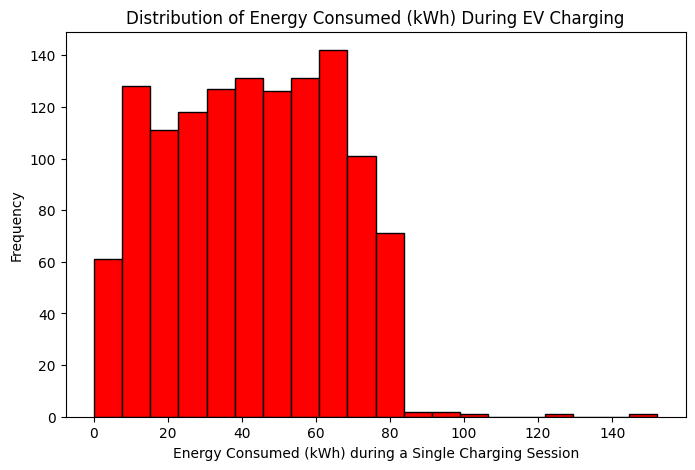

In [ ]:
import pandas as pd

#Load  dataset again
df = pd.read_csv('/content/ev_charging_patterns.csv')

#Now, plotting the histogram
import matplotlib.pyplot as plt

# Histogram for Energy Consumed (kWh)
plt.figure(figsize=(8, 5))
plt.hist(df['Energy Consumed (kWh)'], bins=20, color='red', edgecolor='black')
plt.title('Distribution of Energy Consumed (kWh) During EV Charging')
plt.xlabel('Energy Consumed (kWh) during a Single Charging Session')
plt.ylabel('Frequency')

plt.show()




Why I Used a Histogram for Energy Consumption?

A histogram is a great way to visualize the distribution of a continuous variable like 'Energy Consumed (kWh)'. By plotting a histogram, we can observe the frequency of different ranges of energy consumption during charging sessions. This helps us identify patterns such as whether most vehicles consume similar amounts of energy, or if there is a wide variation. It also allows us to spot any skewness or potential outliers in the data.


**IMPACT OF OUTLIERS**

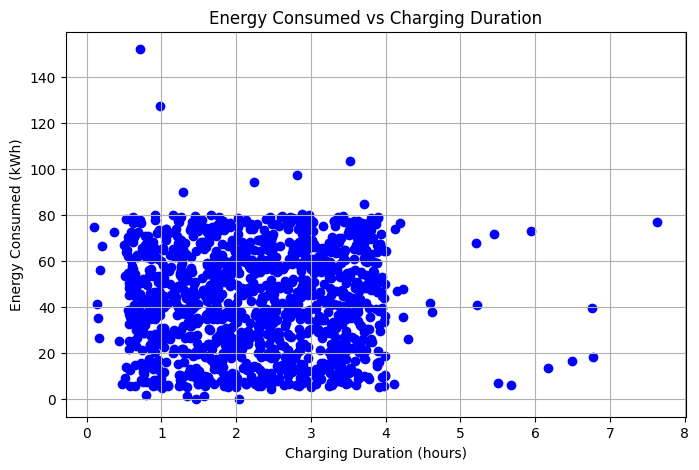

In [ ]:
#Scatter plot between Energy Consumed and Charging Duration
plt.figure(figsize=(8, 5))
plt.scatter(df['Charging Duration (hours)'], df['Energy Consumed (kWh)'], color='blue')
plt.title('Energy Consumed vs Charging Duration')
plt.xlabel('Charging Duration (hours)')
plt.ylabel('Energy Consumed (kWh)')

plt.show()


There are some notable outliers, particularly at the higher energy consumption levels (above 100 kWh) and for charging durations exceeding 5 hours. These may represent unique cases, such as high-capacity vehicles or exceptionally long charging sessions.

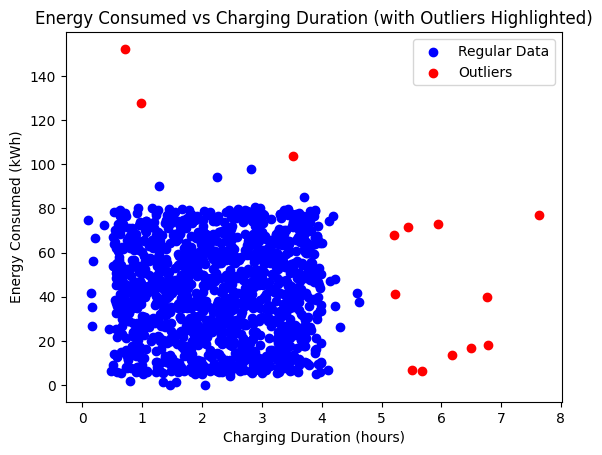

In [ ]:
import matplotlib.pyplot as plt
# Defining thresholds for outliers based on the earlier analysis
energy_threshold = 100  # Anything above 100 kWh is considered an outlier
duration_threshold = 5  # Charging duration above 5 hours considered an outlier

# Separating outliers from regular data
outliers = df[(df['Energy Consumed (kWh)'] > energy_threshold) | (df['Charging Duration (hours)'] > duration_threshold)]
regular_data = df[(df['Energy Consumed (kWh)'] <= energy_threshold) & (df['Charging Duration (hours)'] <= duration_threshold)]


plt.scatter(regular_data['Charging Duration (hours)'], regular_data['Energy Consumed (kWh)'], color='blue', label='Regular Data')

plt.scatter(outliers['Charging Duration (hours)'], outliers['Energy Consumed (kWh)'], color='red', label='Outliers')

plt.title('Energy Consumed vs Charging Duration (with Outliers Highlighted)')
plt.xlabel('Charging Duration (hours)')
plt.ylabel('Energy Consumed (kWh)')

plt.legend()

plt.show()


**Highlighting Outliers**
To improve the plot, I first differentiated the outliers from the regular data points. This would help in visualizing their impact on the overall trend.

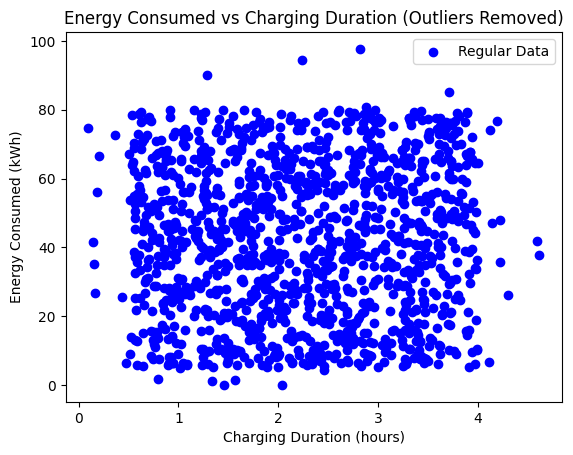

In [ ]:
#  plot without outliers
plt.scatter(regular_data['Charging Duration (hours)'], regular_data['Energy Consumed (kWh)'], color='blue', label='Regular Data')


plt.title('Energy Consumed vs Charging Duration (Outliers Removed)')
plt.xlabel('Charging Duration (hours)')
plt.ylabel('Energy Consumed (kWh)')
plt.legend()


plt.show()


**Analysis:** This plot illustrates the relationship between Energy Consumed (kWh) and Charging Duration (hours) after outliers have been removed. It shows a more concentrated and uniform spread of the data between charging durations of 1 and 4 hours, with energy consumption mostly concentrated between 20 and 80 kWh.

**BIVARIATE ANALYSIS**

<ipython-input-36-3a82bae6c18c>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_energy = data.groupby('Temperature Binned')['Energy Consumed (kWh)'].mean()


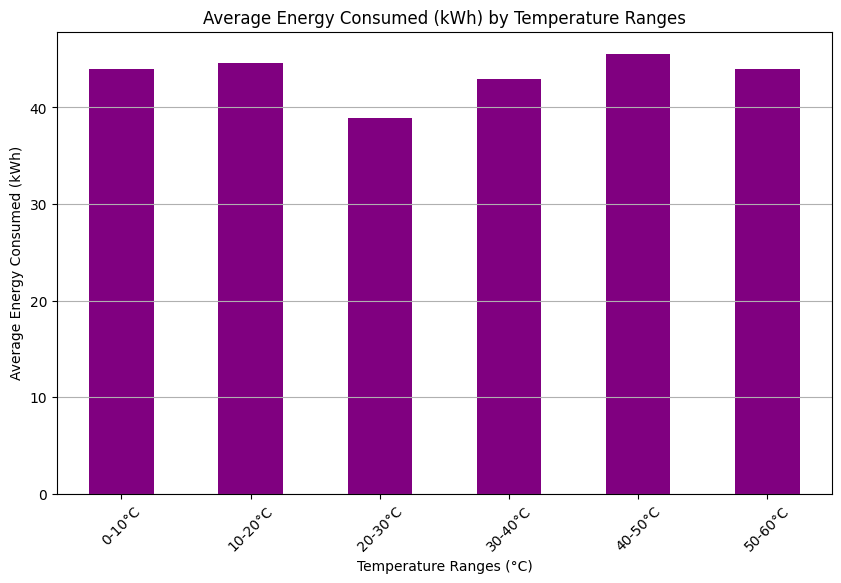

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv('/content/ev_charging_patterns.csv')  # Update the filename accordingly

# Creating bins for temperature ranges
bins = [0, 10, 20, 30, 40, 50, 60]  # Define the bins
labels = ['0-10°C', '10-20°C', '20-30°C', '30-40°C', '40-50°C', '50-60°C']
data['Temperature Binned'] = pd.cut(data['Temperature (°C)'], bins=bins, labels=labels, include_lowest=True)

# Calculate average energy consumed for each temperature bin
average_energy = data.groupby('Temperature Binned')['Energy Consumed (kWh)'].mean()

# Plotting the bar plot
plt.figure(figsize=(10, 6))
average_energy.plot(kind='bar', color='purple')
plt.title('Average Energy Consumed (kWh) by Temperature Ranges')
plt.xlabel('Temperature Ranges (°C)')
plt.ylabel('Average Energy Consumed (kWh)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


**Analysis**
The bar plot demonstrates that energy consumption remains relatively consistent across different temperature ranges, with no drastic variations. The 20-30°C range shows a slightly lower average energy consumption, suggesting that vehicles may operate more efficiently in moderate temperatures. However, overall, temperature does not appear to have a strong impact on the energy consumed during charging, as the average consumption is stable across most temperature ranges.

In [ ]:
import pandas as pd

# Load the dataset
file_path = 'ev_charging_patterns.csv'  # Update this with your actual path if needed
data = pd.read_csv(file_path)

# Get descriptive statistics for numerical columns
descriptive_stats = data.describe()

# Calculating mode for numerical columns separately, since describe() doesn't include it
mode_values = data.mode()

# Combining the results into one DataFrame for better readability
summary_stats = pd.concat([descriptive_stats, mode_values], keys=['Descriptive Stats', 'Mode'])
# Describe statistics (mean, std, min, max, etc.)
summary_stats = df.describe()

# Adding mode manually for reference
mode_values = df.mode().iloc[0]  # mode() may return multiple rows, so take the first mode
summary_stats.loc['mode'] = mode_values

# Display the complete descriptive statistics including the max and mode
print(summary_stats)


# Displaying the summary statistics
print(summary_stats)


       Battery Capacity (kWh)  Charging Start Time  Energy Consumed (kWh)  \
count             1320.000000                 1320            1254.000000   
mean                74.534692  2024-01-28 11:30:00              42.642894   
min                  1.532807  2024-01-01 00:00:00               0.045772   
25%                 62.000000  2024-01-14 17:45:00              23.881193   
50%                 75.000000  2024-01-28 11:30:00              42.691405   
75%                 85.000000  2024-02-11 05:15:00              61.206218   
max                193.003074  2024-02-24 23:00:00             152.238758   
std                 20.626914                  NaN              22.411705   
mode                75.000000  2024-01-01 00:00:00               0.045772   

       Charging Duration (hours)  Charging Rate (kW)  Charging Cost (USD)  \
count                1320.000000         1254.000000          1320.000000   
mean                    2.269377           25.963003            22.551352  

Here's a brief interpretation of some of the statistics:

**Battery Capacity (kWh)**:

The average battery capacity is 74.53 kWh with a max of 193 kWh.
There is some spread in the data with a standard deviation of 20.63 kWh, indicating variation in battery sizes across different vehicles.

**Energy Consumed (kWh):**

On average, 42.64 kWh is consumed per charging session, with a minimum of 0.045 kWh and a maximum of 152.24 kWh.
The consumption distribution has some variability (std 22.41 kWh), and the median is 42.69 kWh, close to the mean, suggesting the distribution is relatively symmetric.

**Charging Duration (hours)**:

The average charging duration is 2.27 hours, with a maximum of 7.64 hours.
Most sessions fall between 1.40 hours (25%) and 3.11 hours (75%).

**Charging Rate (kW)**:

The mean charging rate is 25.96 kW, but it can go as high as 97.34 kW in some cases, with a notable spread (std 14.01 kW), reflecting the use of both fast and slow chargers.

**Charging Cost (USD)**:

The average cost per charging session is $22.55, with a maximum cost of $69.41.

**State of Charge (Start and End)**:

On average, vehicles start charging at 49.13% and end at 75.14% state of charge.

**Distance Driven (since last charge):**

The average distance driven between charges is 153.60 km, with a maximum of 398.36 km and a standard deviation of 86.00 km.

**Temperature (°C):**:

The temperature during charging sessions ranges from -10.72°C to 73.17°C, with an average of 15.26°C.

**Vehicle Age (years):**

The average age of vehicles in the dataset is about 3.61 years, with the maximum vehicle age being 11.69 years. The most common vehicle age (mode) is 7 years.



**CONCLUSION**

The key to maximizing profits lies in efficient station utilization, targeted pricing, and enhanced customer experience through faster charging and dynamic pricing models. Leveraging data from the EV charging patterns, companies can optimize their operations, expand to high-demand locations, and cater to different customer segments more effectively.








**Using ChatGPT in the Project:**

Throughout this project, I utilized ChatGPT as a supportive tool to enhance my understanding of data analysis techniques. I sought guidance on coding practices, graph creation, and statistical analysis. The insights provided helped me refine my approach and deepen my analysis, ensuring a comprehensive exploration of the dataset.